## 0. Configs

In [72]:
import warnings

warnings.filterwarnings('ignore')

## 1. Import libraries and data

In [73]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("../data/cleaned/train_V2_cleaned.csv")

There are 779/2592 guests that have damaged the room

In [74]:
df["outcome_damage_inc"].value_counts()

outcome_damage_inc
0    2592
1     779
Name: count, dtype: int64

## 2. Training the model

### **X, y split**

Split the columns which I will need to train a model.

In [75]:
X = df.drop(['outcome_damage_inc', "outcome_damage_amount", "outcome_profit"], axis=1)
y = df['outcome_damage_inc']

In [76]:
# Sample the classes with `SMOTE`

smote = SMOTE(random_state=1234)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [77]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=81357)

In [78]:
num_feat = ['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc',
       'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic',
       'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd',
       'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit',
       'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl',
       'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size',
       'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no',
       'claims_am', 'nights_booked', 'shop_am', 'shop_use', 'retired',
       'gold_status', 'gender_M', 'gender_V']

### **Standardize numerical values**

In [79]:
# scaler = StandardScaler()

# X_train_stand = X_train.copy()
# X_trainval_stand = X_trainval.copy()
# X_val_stand = X_val.copy()

# X_test_stand = X_test.copy()
# X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])
# X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
# X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
# X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

### **Train the model**

In [80]:
logreg = LogisticRegression(C=10000, max_iter=200)
# logreg.fit(X_train_stand, y_train)
logreg.fit(X_train, y_train)

# print(logreg.score(X_train_stand, y_train))
# print(logreg.score(X_val_stand, y_val))
print(logreg.score(X_train, y_train))
print(logreg.score(X_val, y_val))

0.6017485679831173
0.6


### **Make predictions on the test set**

In [81]:
# y_val_pred = logreg.predict(X_val_stand)
y_val_pred = logreg.predict(X_val)

In [82]:
# y_val_pred_prob = logreg.predict_proba(X_val_stand)
y_val_pred_prob = logreg.predict_proba(X_val)

## 3. Checking the model

### **Evaluate**

Confusion Matrix

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(f"Confusion Matrix:\n {confusion_matrix}")

Confusion Matrix:
 [[256 160]
 [172 242]]


Accuracy

In [84]:
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6


Classification Report

In [85]:
classification_rep = classification_report(y_val, y_val_pred)
print('Classification Report:\n', classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.62      0.61       416
           1       0.60      0.58      0.59       414

    accuracy                           0.60       830
   macro avg       0.60      0.60      0.60       830
weighted avg       0.60      0.60      0.60       830



### **Plotting ROC**

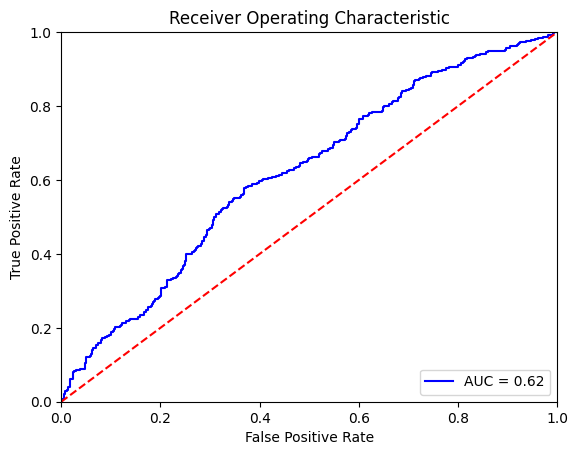

In [86]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = y_val_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3. Make predictions on `score.csv`

### **Import applicant data CSV**, and make adjustments

In [87]:
applicants_data = pd.read_csv("../data/score.csv")

Drop and "`get_dummies`" the same columns as we did for the training data

In [88]:
applicants_data.drop(['score1_pos', 'score1_neg', 'score2_pos',
       'score2_neg', 'score3_pos', 'score3_neg', 'score4_pos', 'score4_neg',
       'score5_pos', 'score5_neg'], axis=1, inplace=True)

applicants_data = pd.get_dummies(applicants_data, columns=['gender'])

applicants_data.fillna(0, inplace=True)

### **Make prediction on the test set**

In [89]:
predicted_damage_incident = logreg.predict(applicants_data)

## 4. Score applicants

I'm not actually scoring applicants (read `IMPORTANT`)

### **Make new DataFrame with `predicted_damage_incident`**

In [90]:
applicants_data["predicted_damage_incident"] = predicted_damage_incident
applicants_data["applicant_id"] = applicants_data.index

applicants_with_predicted_damage_incident = applicants_data[["applicant_id", 'predicted_damage_incident']]

In [91]:
applicants_with_predicted_damage_incident[["predicted_damage_incident"]].value_counts()

predicted_damage_incident
0                            286
1                            214
Name: count, dtype: int64

In [92]:
applicants_with_predicted_damage_incident

,applicant_id,predicted_damage_incident
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
495,495,0
496,496,1
497,497,1
498,498,0


### **Export dataframe**

In [93]:
applicants_with_predicted_damage_incident.to_csv("../data/exported/predicted_damage_incident.csv", index=False)